In [86]:
#импортируем необходимые модули
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score,recall_score,precision_score, auc, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)
import plotly.figure_factory as ff
import plotly.express as px
from IPython.display import Markdown as md
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
import keras
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import LearningRateScheduler
import math
from collections.abc import Iterable

Необходимо подготовить информацию, с которой мы и будем применять алгоритмы машинного обучения

In [87]:
df =  pd.read_csv('results.csv')

In [88]:
df["date"] = pd.to_datetime(df["date"])

In [89]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [90]:
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

Используемый набор данных будет представлять собой игры FIFA в период с 2018 года, начиная с чемпионата мира 2018 года и заканчивая последними играми перед чемпионатом мира 2022 года. Идея состоит в том, чтобы проанализировать именно матчи, сыгранные при подготовке и отборе на ЧМ.

In [91]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
44529,2023-03-28,United Arab Emirates,Thailand,2,0,Friendly,Abu Dhabi,United Arab Emirates,False
44530,2023-03-28,Uzbekistan,Venezuela,1,1,Friendly,Jeddah,Saudi Arabia,True
44531,2023-03-28,Eswatini,Cape Verde,0,1,African Cup of Nations qualification,Mbombela,South Africa,True
44533,2023-03-28,Namibia,Cameroon,2,1,African Cup of Nations qualification,Soweto,South Africa,True
44556,2023-03-29,Rwanda,Benin,1,1,African Cup of Nations qualification,Kigali,Rwanda,False


Ставим ограничения по дате с конца ЧМ 2018 по Начало ЧМ 2022

In [92]:
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)

In [93]:
df = df[(df["date"] <= "2022-10-19")].reset_index(drop=True)

In [94]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
3739,2022-09-27,Ivory Coast,Guinea,3,1,Friendly,Amiens,France,True
3740,2022-09-27,South Korea,Cameroon,1,0,Friendly,Seoul,South Korea,False
3731,2022-09-27,Costa Rica,Uzbekistan,2,1,Friendly,Suwon,South Korea,True
3763,2022-09-30,Fiji,Solomon Islands,1,0,MSG Prime Minister's Cup,Luganville,Vanuatu,True
3764,2022-10-01,Saint Vincent and the Grenadines,Grenada,1,5,Friendly,Kingstown,Saint Vincent and the Grenadines,False


In [95]:
df.home_team.value_counts() #считаем кол-во цникальных повторений в колонке home_team

United States               45
Mexico                      40
Japan                       38
Qatar                       37
Bahrain                     37
                            ..
Chameria                     1
Bhutan                       1
Alderney                     1
Saint Helena                 1
Northern Mariana Islands     1
Name: home_team, Length: 247, dtype: int64

Создаем таблицу рангов

In [96]:
rank = pd.read_csv('fifa_ranking-2022-12-22.csv')

In [97]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)
rank = rank[(rank["rank_date"] <= "2022-10-19")].reset_index(drop=True)

In [98]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") # в разных таблицах у одинаковаых стран могут быть разные названия 

In [99]:
ranking_df = pd.pivot_table(data = rank, 
                            values = 'total_points',
                            index = 'country_full',
                            columns = 'rank_date').fillna(0.0)
ranking_df.head()

rank_date,2018-08-16,2018-09-20,2018-10-25,2018-11-29,2018-12-20,2019-02-07,2019-04-04,2019-06-14,2019-07-25,2019-09-19,...,2021-08-12,2021-09-16,2021-10-21,2021-11-19,2021-12-23,2022-02-10,2022-03-31,2022-06-23,2022-08-25,2022-10-06
country_full,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1068.0,1068.0,1068.0,1068.0,1068.0,1066.0,1057.0,1058.0,1058.0,1062.0,...,1045.34,1045.34,1045.34,1049.77,1049.77,1049.77,1049.77,1023.04,1023.04,1023.04
Albania,1384.0,1383.0,1372.0,1372.0,1372.0,1372.0,1368.0,1362.0,1362.0,1372.0,...,1359.83,1368.73,1374.33,1374.98,1374.98,1374.98,1371.86,1361.81,1361.81,1354.11
Algeria,1351.0,1343.0,1339.0,1347.0,1347.0,1349.0,1348.0,1346.0,1463.0,1466.0,...,1498.75,1498.62,1509.04,1508.54,1516.51,1460.93,1461.26,1480.59,1480.59,1489.10
American Samoa,908.0,908.0,908.0,908.0,908.0,908.0,908.0,908.0,900.0,900.0,...,900.27,900.27,900.27,900.27,900.27,900.27,900.27,900.27,900.27,900.27
Andorra,1120.0,1121.0,1109.0,1111.0,1111.0,1111.0,1099.0,1082.0,1082.0,1075.0,...,1031.64,1033.27,1038.88,1030.28,1030.28,1030.28,1040.13,1028.70,1028.70,1035.20


Далее совергим слияние, чтоб получить информацию о рангах и матчах в одном датасете

In [100]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [101]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [102]:
df_wc_ranked[(df_wc_ranked.home_team == "Portugal") | (df_wc_ranked.away_team == "Portugal")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2458,2021-10-12,Portugal,Luxembourg,5,0,FIFA World Cup qualification,Faro-Loulé,Portugal,False,1674.90,1661.51,7.0,-1.0,1244.55,1238.59,94.0,-2.0
2517,2021-11-11,Republic of Ireland,Portugal,0,0,FIFA World Cup qualification,Dublin,Republic of Ireland,False,1430.59,1418.70,51.0,1.0,1681.73,1674.90,8.0,1.0
2573,2021-11-14,Portugal,Serbia,1,2,FIFA World Cup qualification,Lisbon,Portugal,False,1681.73,1674.90,8.0,1.0,1527.34,1515.97,25.0,-3.0
2817,2022-03-24,Portugal,Turkey,3,1,FIFA World Cup qualification,Porto,Portugal,False,1660.25,1660.25,8.0,0.0,1472.72,1472.72,39.0,2.0
2900,2022-03-29,Portugal,North Macedonia,2,0,FIFA World Cup qualification,Porto,Portugal,False,1660.25,1660.25,8.0,0.0,1367.23,1367.23,67.0,0.0
2976,2022-06-02,Spain,Portugal,1,1,UEFA Nations League,Sevilla,Spain,False,1709.19,1704.75,7.0,0.0,1674.78,1660.25,8.0,0.0
3030,2022-06-05,Portugal,Switzerland,4,0,UEFA Nations League,Lisbon,Portugal,False,1674.78,1660.25,8.0,0.0,1635.32,1642.83,14.0,0.0
3101,2022-06-09,Portugal,Czech Republic,2,0,UEFA Nations League,Lisbon,Portugal,False,1674.78,1660.25,8.0,0.0,1500.62,1510.42,33.0,2.0
3154,2022-06-12,Switzerland,Portugal,1,0,UEFA Nations League,Geneva,Switzerland,False,1635.32,1642.83,14.0,0.0,1674.78,1660.25,8.0,0.0
3328,2022-09-27,Portugal,Spain,0,1,UEFA Nations League,Braga,Portugal,False,1678.65,1678.65,9.0,0.0,1716.93,1716.93,6.0,0.0


Далее введем те "фишки", с помощью которых будет определяться исход матча. 

In [103]:
df = df_wc_ranked

In [104]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [105]:
df[["result", "home_team_points", "away_team_points"]] = results

Игровые очки составляют 3 за победу, 1 за ничью и 0 за проигрыш и отличаются от ранговых очков FIFA, которые уже есть в базе данных.

Теперь мы создаем столбцы, которые помогут в создании функций: разница в рейтинге, очки, набранные в игре, по сравнению с рейтингом команды, а также разница голов в игре. Все функции, не являющиеся различиями, должны быть созданы для двух команд (в гостях и дома).

In [106]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

Также необходимо разделить на "домашние" и "гостевые" команды, объединю их и рассчитаю значения для прошедших игр. После этого я снова разделю и объединю их, получив исходный набор данных. Этот процесс оптимизирует создание функций

In [107]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [108]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [109]:
team_stats = pd.concat([home_team, away_team])

In [110]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2018-08-18,Andorra,0,0,130.0,77.0,0.0,1120.00,2,53.0,0.012987,1
1,2018-08-18,Grenada,1,5,168.0,54.0,0.0,980.00,1,114.0,0.000000,0
2,2018-08-18,Guatemala,1,0,146.0,181.0,0.0,1064.00,0,-35.0,0.016575,3
3,2018-08-20,Barbados,2,2,160.0,54.0,0.0,1005.00,2,106.0,0.018519,1
4,2018-08-26,Barbados,0,0,160.0,181.0,0.0,1005.00,2,-21.0,0.005525,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3332,2022-09-27,Serbia,2,0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
3333,2022-09-27,Slovenia,1,1,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
3334,2022-09-27,Cyprus,1,5,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
3335,2022-09-27,Northern Ireland,1,3,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


In [111]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Теперь у нас есть база данных, готовая для создания прогностических функций. Они будут:

1) Средние голы команды в цикле Кубка мира.

2) Средние голы команды в последних 5 играх.

3) Среднее количество голов, забитых командой в цикле Кубка мира.

4) Среднее количество голов, забитых командой в последних 5 играх.

5) Средний рейтинг ФИФА, с которым команда столкнулась в цикле чемпионата мира.

6) Средний рейтинг FIFA, с которым команда сталкивалась в последних 5 играх.

7) Очки FIFA, выигранные в цикле.

8) FIFA Points заработаны в последних 5 играх.

9) Средние игровые очки в цикле.

10) Средние игровые очки за последние 5 игр.

11) Средние игровые очки по рангам, с которыми столкнулись в цикле.

12) Средние игровые очки по рангам, с которыми они сталкивались в последних 5 играх.


In [112]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [113]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [114]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [115]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

Чтобы объединить базу данных, необходимо добавить суффиксы «home» и «away» для каждого столбца. После этого данные готовы к объединению.

In [116]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [117]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [118]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [119]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

далее необходимо проверить важность матча

In [120]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [121]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [122]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

И, после этого, мы выбираем только столбцы, которые помогут в анализе признаков.

In [123]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3332,2022-09-27,Norway,Serbia,36.0,25.0,0,2,1,11.0,0.0,...,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0
3333,2022-09-27,Sweden,Slovenia,20.0,65.0,1,1,2,-45.0,0.0,...,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0
3334,2022-09-27,Kosovo,Cyprus,106.0,108.0,5,1,0,-2.0,0.0,...,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0
3335,2022-09-27,Greece,Northern Ireland,49.0,58.0,3,1,0,-9.0,1.0,...,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0
3336,2022-09-30,Fiji,Solomon Islands,163.0,137.0,1,0,0,26.0,0.0,...,1.500000,1.4,0.009432,0.008868,1.714286,2.0,0.010013,0.012387,1,0


In [124]:
base_df_no_fg = base_df.dropna()# без товарищеских матчей

In [125]:
base_df_no_fg

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
4,2018-08-26,Barbados,Cuba,160.0,181.0,0,0,2,-21.0,0.0,...,1.000000,1.0,0.018519,0.018519,0.000000,0.0,0.000000,0.000000,0,1
6,2018-08-29,Barbados,Cuba,160.0,181.0,0,2,1,-21.0,0.0,...,1.000000,1.0,0.012022,0.012022,0.500000,0.5,0.003125,0.003125,0,1
31,2018-09-06,Mongolia,Guam,186.0,190.0,1,1,2,-4.0,0.0,...,3.000000,3.0,0.016216,0.016216,0.000000,0.0,0.000000,0.000000,1,0
32,2018-09-06,Nepal,Bhutan,161.0,183.0,4,0,0,-22.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0
33,2018-09-06,Bangladesh,Pakistan,194.0,201.0,1,0,0,-7.0,0.0,...,1.500000,1.5,0.008197,0.008197,3.000000,3.0,0.018634,0.018634,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,2022-09-27,Norway,Serbia,36.0,25.0,0,2,1,11.0,0.0,...,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0
3333,2022-09-27,Sweden,Slovenia,20.0,65.0,1,1,2,-45.0,0.0,...,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0
3334,2022-09-27,Kosovo,Cyprus,106.0,108.0,5,1,0,-2.0,0.0,...,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0
3335,2022-09-27,Greece,Northern Ireland,49.0,58.0,3,1,0,-9.0,1.0,...,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0


Далее мы переходим уже к анализу данных

Для простоты будем рассматривать ничью как поражение гостевой комнады, чтоб решать именно бинарную задачу

In [126]:
df = base_df_no_fg

In [127]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

In [128]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [129]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

In [130]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

In [131]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")


In [132]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [133]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [134]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

In [135]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")


Что касается различий в рангах, игровых очках по рангам и средних игровых очках по рангам, две версии (полная и 5 игр) не так похожи. Итак, мы будем использовать оба.

Исходя из этого, окончательные характеристики:

rank_dif

goals_dif

goals_dif_l5

goals_suf_dif

goals_suf_dif_l5

dif_rank_agst

dif_rank_agst_l5

goals_per_ranking_dif

dif_points_rank

dif_points_rank_l5

is_friendly

In [136]:
def create_db(df):
    
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [137]:
model_db = create_db(df)

In [138]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3333,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3334,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3335,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


In [139]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [140]:
model_db = create_db(df)

In [141]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3333,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3334,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3335,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


# Построение различных моделей(RandomForest и GradientBoosting)

In [142]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [144]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [145]:
gb = gb_cv.best_estimator_

In [146]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=10,
                           n_estimators=200, random_state=5)

In [147]:
params_rf = {"max_depth": [5, 10, 20],
                "min_samples_split": [10, 20],
                "max_leaf_nodes": [175, 200, 150],
                "min_samples_leaf": [5, 10],
                "n_estimators": [250, 300],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175, 200, 150],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20],
                         'n_estimators': [250, 300]},
             verbose=False)

In [148]:
rf = rf_cv.best_estimator_

In [149]:
rf

RandomForestClassifier(max_depth=5, max_features='sqrt', max_leaf_nodes=175,
                       min_samples_leaf=5, min_samples_split=20,
                       n_estimators=250, random_state=1)

In [150]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

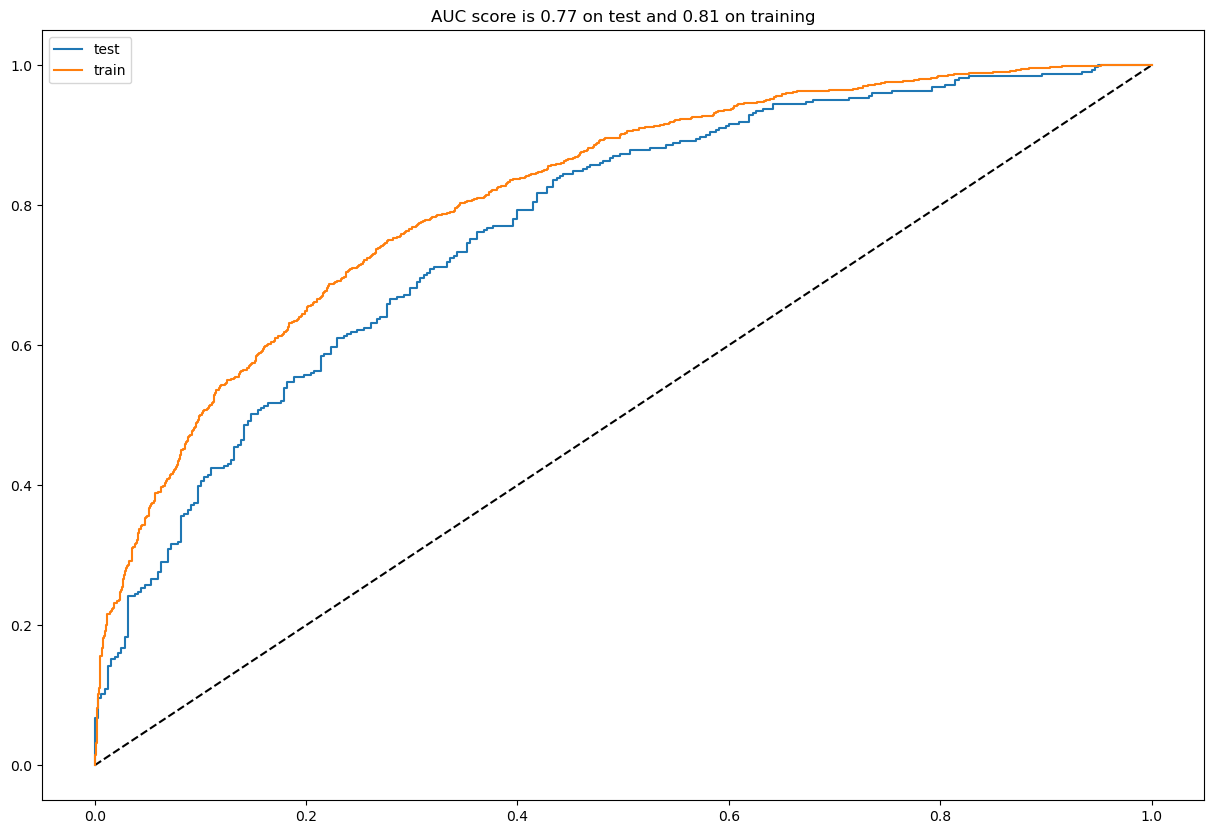

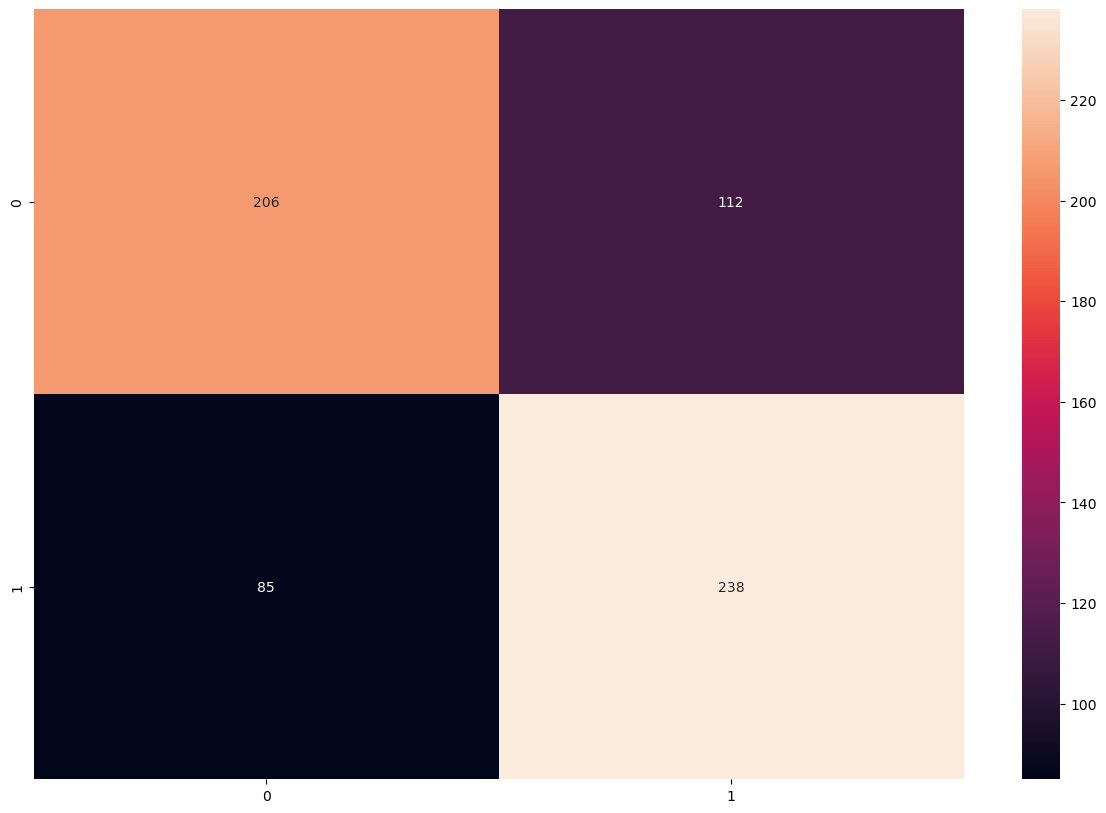

In [151]:
analyze(gb)

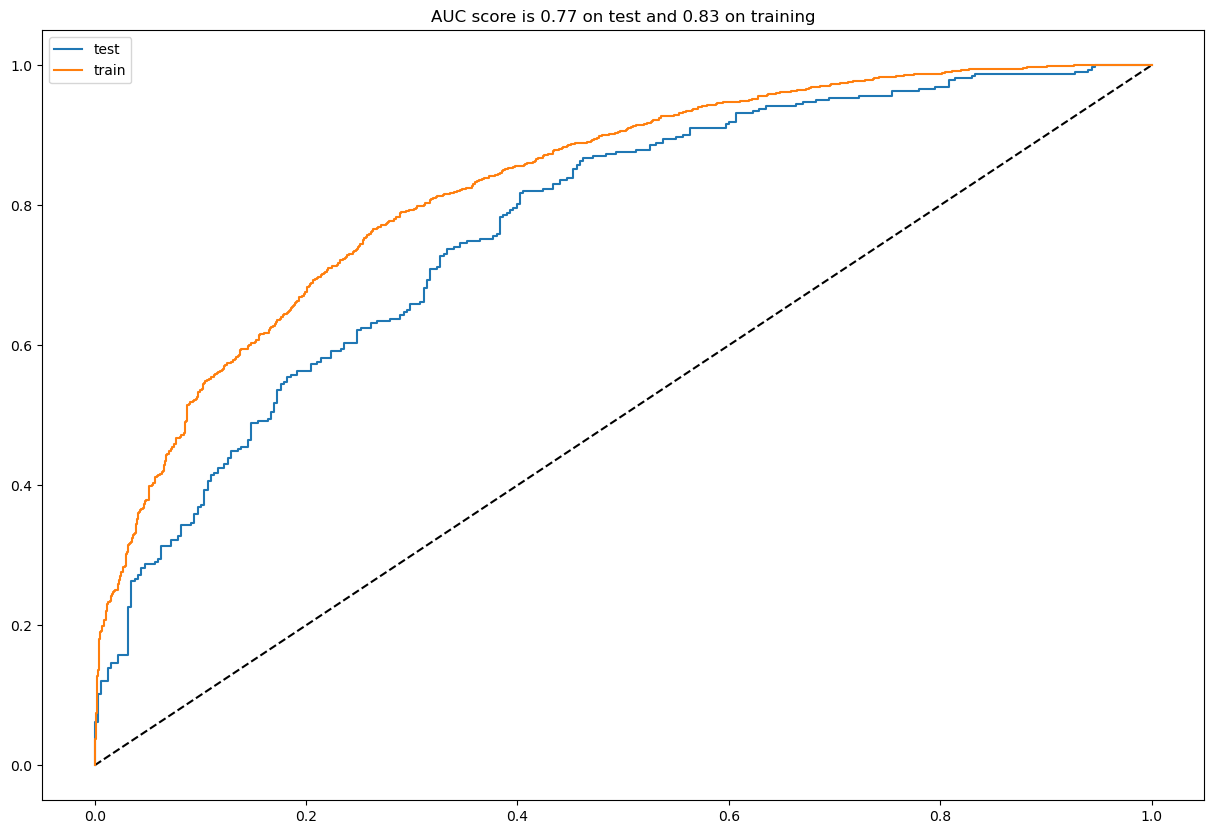

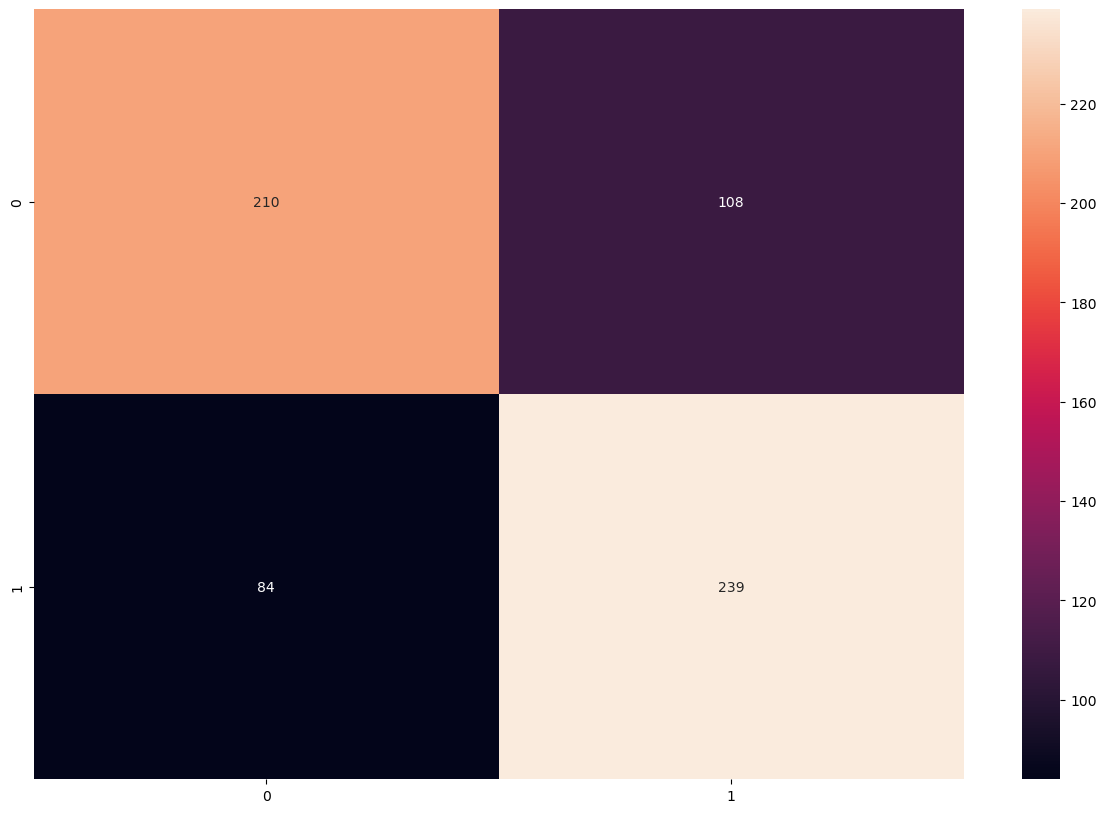

In [152]:
analyze(rf)

Модель Random Forest немного лучше, но, похоже, не подходит. Итак, мы будем использовать модель Gradient Boosting.

# Симулятор ЧМ

Прежде всего, надо создать игры чемпионата мира по футболу. Для этого я наберу в википедии команды и матчи группового этапа.

In [153]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [154]:
for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1

        if any("Player/Official" in c for c in cols):
            end_pos = i + 1

print(start_pos, end_pos)

9 83


In [155]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos - 1, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        if group_count == len(groups):
            break
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [156]:
table

{'A': [['Netherlands', 0, []],
  ['Senegal', 0, []],
  ['Ecuador', 0, []],
  ['Qatar', 0, []]],
 'B': [['England', 0, []],
  ['United States', 0, []],
  ['Iran', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Poland', 0, []],
  ['Mexico', 0, []],
  ['Saudi Arabia', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Tunisia', 0, []],
  ['Denmark', 0, []]],
 'E': [['Japan', 0, []],
  ['Spain', 0, []],
  ['Germany', 0, []],
  ['Costa Rica', 0, []]],
 'F': [['Morocco', 0, []],
  ['Croatia', 0, []],
  ['Belgium', 0, []],
  ['Canada', 0, []]],
 'G': [['Brazil', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []],
  ['Serbia', 0, []]],
 'H': [['Portugal', 0, []],
  ['South Korea', 0, []],
  ['Uruguay', 0, []],
  ['Ghana', 0, []]]}

Выше мы также храним очки команды в группе и ее вероятности победы в каждой игре. Среднее значение вероятности победы команды будет использоваться для тай-брейка, если две команды наберут одинаковое количество очков.

In [157]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

In [158]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [159]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Поскольку модель моделирует, выиграет первая команда или нет, необходимо создать некоторые критерии для определения ничьей. Кроме того, поскольку у нас нет домашнего преимущества на чемпионате мира, идея состоит в том, чтобы предсказать игру дважды, поменяв первую команду и вторую команду. Команда с наибольшим средним значением вероятностей будет назначена победителем. На групповом этапе, если «хозяева» выиграют как первая команда и проиграют как вторая команда, или если «хозяева» выиграют как вторая команда и проиграют первой команде, в этом матче будет назначена ничья.

In [160]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: 
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]:
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.63 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.63 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.61 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.71 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.76 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.63 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Winner Wales with 0.51 probability
Group B - England vs. United States: Draw
Group B - Wales vs. England: Winner England with 0.63 probability
Group B - Iran vs. United States: Winner United States with 0.60 probability


Group B advanced: 
England -------- 7
United S

In [161]:
advanced = advanced_group

In [162]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [163]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.54
Argentina vs. Denmark: Argentina advances with prob 0.62
Spain vs. Croatia: Spain advances with prob 0.58
Brazil vs. Uruguay: Brazil advances with prob 0.65
Senegal vs. England: England advances with prob 0.65
Mexico vs. France: France advances with prob 0.59
Germany vs. Belgium: Belgium advances with prob 0.52
Switzerland vs. Portugal: Portugal advances with prob 0.55
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.51
Spain vs. Brazil: Brazil advances with prob 0.55
England vs. France: France advances with prob 0.52
Belgium vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.52
France vs. Portugal: Portugal advances with prob 0.53
----------
Starting simulation of Final
----------


Arge